# BT4222 Project -Toxic Comments Classifier (Part 2 ML Severe_Toxic,Obscene,Identity_hate)


This notebook contains the code and results of the modelling for the class severe_toxic,obscene and identity_hate. For full explanation and description of the output, please refer to the report. There is another ML modelling notebook attached as well which contains modelling for 3 other classes namely toxic, threat and insult.

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import RegexpTokenizer,sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier,ExtraTreesClassifier
from sklearn import tree, manifold,datasets
from sklearn.model_selection import KFold, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, make_scorer , recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV,KFold, cross_val_score
from sklearn.cluster import KMeans
import lightgbm as lgb
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.model_selection import validation_curve
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.decomposition import PCA

from hyperopt import hp
from hyperopt.pyll import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")
#project_dir = r"C:\Users\User\Desktop\JeremyWork\BT4222\"

In [2]:
df_train = pd.read_csv("cleaned_train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train['comment_text'].fillna("unknown", inplace=True)
df_test['comment_text'].fillna("unknown", inplace=True)

In [4]:
label = list(df_train.columns[2:])

In [6]:
train_y = df_train[label]

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                              analyzer='word',
                              norm='l2',
                              ngram_range=(1,1),
                              stop_words="english",
                              lowercase=True,
                             )

data = tfidf.fit_transform(df_train['comment_text'])
tf_train_x = tfidf.transform(df_train['comment_text'])

In [212]:
## Credits to https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for code

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

## Severe Toxic Modelling

### L1 Models Optimization

In [9]:
def bayes_opt(classifier,param_space,X_train,y_train,metric):

    def objective_function(param_space):

        clf = classifier(random_state=1234, **param_space)
        score = cross_val_score(clf, X_train,y_train, cv=5,scoring=metric).mean()
        return {'loss': -score, 'status': STATUS_OK}
    
    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=100, 
                      trials=trials,
                      rstate= np.random.RandomState(4222)
                     )

    loss = [x['result']['loss'] for x in trials.trials]
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)

In [10]:
log_param_space1 = {"penalty": hp.choice("penalty", ['l1','l2']),
                   "fit_intercept" : hp.choice("fit_intercept", [True]),
                   "C": hp.choice("C", list(np.logspace(-3,3,300))),
                   "max_iter":hp.choice("max_iter", [50,100,200,500]),
                    "class_weight":hp.choice("class_weight", ["balanced",None]),
                   "n_jobs":hp.choice("n_jobs", [3])}

bayes_opt(LogisticRegression,log_param_space1,tf_train_x,train_y['severe_toxic'],"roc_auc")

100%|██████████| 100/100 [4:35:55<00:00, 165.55s/it, best loss: -0.9861749283169351]   

##### Results
Score best parameters:  0.9861749283169351
Best parameters:  {'C': 112, 'class_weight': 0, 'fit_intercept': 0, 'max_iter': 2, 'n_jobs': 0, 'penalty': 1}


In [11]:
lgb_param_space1 = {"boosting_type": hp.choice("boosting_type",["gbdt","dart","goss"]),
                    "learning_rate":hp.choice("learning_rate", [0.01,0.05,0.1,0.2,0.3]),
                  "gamma":scope.int(hp.quniform('gamma', 1, 5, 1)),
                  'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
                  'reg_alpha': hp.choice('reg_alpha', [1e-2, 0.1, 1, 100,200,500]),
                  'reg_lambda':hp.choice('reg_lambda', [1e-2, 0.1, 1, 100,200,500]),
                  "n_estimators" : hp.choice("n_estimators", [5,10,20,50,100]),
                  "n_job":hp.choice('n_job',[3])}

bayes_opt(lgb.LGBMClassifier,lgb_param_space1,tf_train_x,train_y['severe_toxic'],"roc_auc")

100%|██████████| 100/100 [2:56:48<00:00, 106.09s/it, best loss: -0.9817029039104985] 

##### Results
Score best parameters:  0.9817029039104985
Best parameters:  {'boosting_type': 0, 'colsample_by_tree': 0.50104456858092, 'gamma': 3.0, 'learning_rate': 2, 'n_estimators': 4, 'n_job': 0, 'reg_alpha': 0, 'reg_lambda': 2}


In [12]:
from tqdm import tqdm

embeddings_index = {}
embedding_dir = r"D:\Y3S1\BT4222"
f = open(os.path.join(embedding_dir,'glove.840B.300d.txt'), encoding="utf8")

for line in tqdm(f):
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

2196017it [08:58, 4077.98it/s]


In [13]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    #words = str(s).lower().decode('utf-8')
    words = word_tokenize(s)
    #words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [14]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(df_train['comment_text'])]
# xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]
xtrain_glove = np.array(xtrain_glove)

100%|██████████| 159571/159571 [02:07<00:00, 1250.54it/s]


In [23]:
log_param_space1 = {"penalty": hp.choice("penalty", ['l1','l2']),
                   "fit_intercept" : hp.choice("fit_intercept", [True]),
                   "C": hp.choice("C", list(np.logspace(-3,3,300))),
                    "max_iter":hp.choice("max_iter", [100,200,500]),
                   "class_weight":hp.choice("class_weight", ["balanced"]),
                   "n_jobs":hp.choice("n_jobs", [3])}

bayes_opt(LogisticRegression,log_param_space1,xtrain_glove,train_y['severe_toxic'],"roc_auc")

100%|██████████| 100/100 [15:19:29<00:00, 551.70s/it, best loss: -0.9845579785805215]   

##### Results
Score best parameters:  0.9845579785805215
Best parameters:  {'C': 124, 'class_weight': 0, 'fit_intercept': 0, 'max_iter': 2, 'n_jobs': 0, 'penalty': 1}


In [16]:
lgb_param_space1 = {"boosting_type": hp.choice("boosting_type",["gbdt","dart","goss"]),
                    "learning_rate":hp.choice("learning_rate", [0.01,0.05,0.1,0.2,0.3]),
                  "gamma":scope.int(hp.quniform('gamma', 1, 5, 1)),
                  'reg_alpha': hp.choice('reg_alpha', [1e-5,1e-2, 0.1, 1, 100,200]),
                  'reg_lambda':hp.choice('reg_lambda', [1e-2, 0.1, 1, 100,200]),
                  "n_estimators" : hp.choice("n_estimators", [10,50,100,300]),
                    "class_weight":hp.choice("class_weight", ["balanced",None]),
                  "n_job":hp.choice('n_job',[3])}

bayes_opt(lgb.LGBMClassifier,lgb_param_space1,xtrain_glove,train_y['severe_toxic'],"roc_auc")

100%|██████████| 100/100 [6:17:37<00:00, 226.57s/it, best loss: -0.9854742550372805] 

##### Results
Score best parameters:  0.9854742550372805
Best parameters:  {'boosting_type': 1, 'class_weight': 0, 'gamma': 4.0, 'learning_rate': 3, 'n_estimators': 3, 'n_job': 0, 'reg_alpha': 1, 'reg_lambda': 4}


### Building Layer 1

In [25]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=1234, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [26]:
#for models without predict_proba
from sklearn.calibration import CalibratedClassifierCV

# Class to extend the Sklearn classifier
class SklearnHelper2(object):
    def __init__(self, clf, seed=1234, params=None):
        params['random_state'] = seed
        self.clf = CalibratedClassifierCV(clf(**params))

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [271]:
def get_oof(classifier, X_train, y_train, X_test, ntrain, ntest):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((5, ntest))
    
    skf = StratifiedKFold(n_splits=5,random_state=1234)
    
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        
        # train-test split in each fold
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        
        model = classifier.fit(X_train_cv, y_train_cv)
        
        oof_train[test_index] = model.predict_proba(X_test_cv)[:,1]
        oof_test_skf[i, :] = model.predict_proba(X_test)[:,1]
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [272]:
# first layers

tf_log_params = {
    'penalty':'l2',
    'C': list(np.logspace(-3,3,300))[112],
    'class_weight':'balanced',
    'fit_intercept':True,
    'random_state':1234,
    'max_iter':200,
    'n_jobs':3
}

tf_lgb_params = {
    'boosting_type': 'gbdt', 
    'colsample_by_tree': 0.50104456858092, 
    'gamma': 3.0, 
    'learning_rate': 0.1, 
    'n_estimators': 100, 
    'reg_alpha': 1e-2, 
    'reg_lambda': 2,
    'random_state' :1234,
    'n_jobs':3
}

glove_log_params = {
    'penalty':'l1',
    'C': list(np.logspace(-3,3,300))[124],
    'class_weight':'balanced',
    'fit_intercept':True,
    'random_state':1234,
    'max_iter':500,
    'n_jobs':3
}

glove_lgb_params = {
    'boosting_type': "dart", 
    'gamma': 4.0, 
    'learning_rate': 0.2, 
    'n_estimators': 300, 
    'reg_alpha': 1e-2, 
    'reg_lambda': 200,
    'random_state' :1234,
    'n_jobs':3
}

In [273]:
# Create 4 objects that represent our 4 models
log_tf = SklearnHelper(clf=LogisticRegression, seed=1234, params=tf_log_params)
lgb_tf = SklearnHelper(clf=lgb.LGBMClassifier, seed=1234, params=tf_lgb_params)
log_glove = SklearnHelper(clf=LogisticRegression, seed=1234, params=glove_log_params)
lgb_glove = SklearnHelper(clf=lgb.LGBMClassifier, seed=1234, params=glove_lgb_params)

In [63]:
# filter out -1 in test set
df_test_label = pd.read_csv("test_labels.csv")
df_test_label = df_test_label[df_test_label.toxic != -1]
test_id = list(df_test_label.id)

df_test = pd.read_csv("cleaned_test.csv")
df_test = df_test[df_test.id.isin(test_id)]
df_test['comment_text'].fillna("unknown", inplace=True)

tf_X_test = tfidf.transform(df_test['comment_text'])
glove_X_test = [sent2vec(x) for x in tqdm(df_test['comment_text'])]
glove_X_test = np.array(glove_X_test)
test_y = df_test_label[label]

100%|██████████| 63978/63978 [09:53<00:00, 107.75it/s]


In [274]:
ntrain = len(df_train)
ntest = len(df_test)

In [275]:
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold
                                    )

In [276]:
log_tf_train, log_tf_test = get_oof(log_tf, tf_train_x,train_y['severe_toxic'], tf_X_test, ntrain, ntest) 

In [277]:
lgb_tf_train, lgb_tf_test = get_oof(lgb_tf, tf_train_x,train_y['severe_toxic'], tf_X_test, ntrain, ntest) 

In [278]:
log_glove_train, log_glove_test = get_oof(log_glove, xtrain_glove,train_y['severe_toxic'], glove_X_test, ntrain, ntest)

In [279]:
lgb_glove_train, lgb_glove_test = get_oof(lgb_glove,xtrain_glove,train_y['severe_toxic'], glove_X_test, ntrain, ntest) 

In [280]:
final_X_train = np.concatenate((log_tf_train, lgb_tf_train, log_glove_train, lgb_glove_train), axis=1)
final_X_test = np.concatenate((log_tf_test, lgb_tf_test, log_glove_test, lgb_glove_test), axis=1)

### Correlation of Train and Test Results

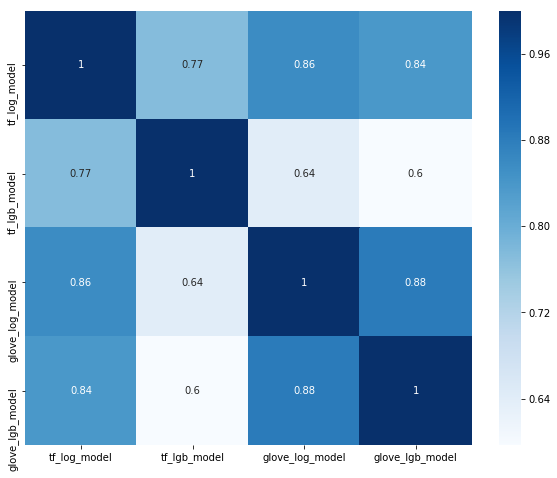

In [281]:
temp = pd.DataFrame(final_X_train,columns=["tf_log_model","tf_lgb_model","glove_log_model","glove_lgb_model"])
corr=temp.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True,cmap='Blues')

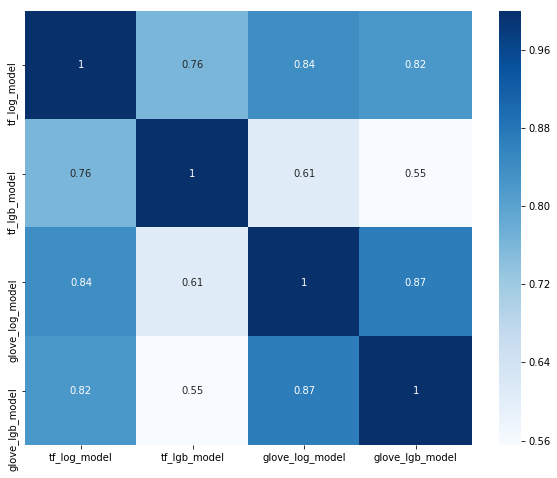

In [282]:
temp2 = pd.DataFrame(final_X_test,columns=["tf_log_model","tf_lgb_model","glove_log_model","glove_lgb_model"])
corr=temp2.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True,cmap='Blues')

### L2 Model Optimization and Selection

In [46]:
from xgboost import XGBClassifier

In [47]:
xgb_param_space1 = {"learning_rate": hp.choice("learning_rate", [0.05, 0.07, 0.1, 0.15, 0.2]),
                   "gamma": scope.int(hp.quniform("gamma", 0,4,1)),
                   "subsample": hp.uniform("subsample", 0.6, 1.0),
                   "colsample_bytree": hp.uniform("colsample_by_tree", 0.4, 1),
                   "reg_alpha": hp.choice("reg_alpha", [1e-5, 0.1, 1, 100]),
                   "reg_lambda": hp.choice("reg_lambda", [1e-5, 1e-2, 0.1]),
                   "n_estimators": hp.choice("n_estimators", [100, 200, 500])
                  }
bayes_opt(XGBClassifier, xgb_param_space1, final_X_train,train_y['severe_toxic'], "roc_auc")

100%|██████████| 100/100 [2:02:43<00:00, 73.64s/it, best loss: -0.9881726170374925]  

##### Results
Score best parameters:  0.9881726170374925
Best parameters:  {'colsample_by_tree': 0.6186679058185952, 'gamma': 4.0, 'learning_rate': 2, 'n_estimators': 0, 'reg_alpha': 2, 'reg_lambda': 0, 'subsample': 0.9500402723893966}


In [48]:
lgb_param_space1 = {"boosting_type": hp.choice("boosting_type",["gbdt","dart","goss"]),
                    "learning_rate":hp.choice("learning_rate", [0.01,0.05,0.1,0.5,1]),
                  "gamma":scope.int(hp.quniform('gamma', 1, 5, 1)),
                  'reg_alpha': hp.choice('reg_alpha', [1e-5,1e-2, 0.1, 1, 100,200]),
                  'reg_lambda':hp.choice('reg_lambda', [1e-2, 0.1, 1, 100,200]),
                  "n_estimators" : hp.choice("n_estimators", [10,50,100,300]),
                    "class_weight":hp.choice("class_weight", ["balanced",None]),
                  "n_job":hp.choice('n_job',[3])}

bayes_opt(lgb.LGBMClassifier,lgb_param_space1,final_X_train,train_y['severe_toxic'],"roc_auc")

100%|██████████| 100/100 [23:00<00:00, 13.80s/it, best loss: -0.9878939135637242]

##### Results
Score best parameters:  0.9878939135637242
Best parameters:  {'boosting_type': 2, 'class_weight': 1, 'gamma': 2.0, 'learning_rate': 2, 'n_estimators': 2, 'n_job': 0, 'reg_alpha': 1, 'reg_lambda': 3}


In [49]:
log_param_space1 = {"penalty": hp.choice("penalty", ['l1','l2']),
                   "fit_intercept" : hp.choice("fit_intercept", [True]),
                   "C": hp.choice("C", list(np.logspace(-3,3,300))),
                   "max_iter":hp.choice("max_iter", [100,200,500,1000]),
                    "class_weight":hp.choice("class_weight", ["balanced",None]),
                   "n_jobs":hp.choice("n_jobs", [3])}

bayes_opt(LogisticRegression,log_param_space1,final_X_train,train_y['severe_toxic'],"roc_auc")

100%|██████████| 100/100 [05:21<00:00,  3.21s/it, best loss: -0.9877164925999924]

##### Results
Score best parameters:  0.9877164925999924
Best parameters:  {'C': 49, 'class_weight': 1, 'fit_intercept': 0, 'max_iter': 2, 'n_jobs': 0, 'penalty': 1}


In [283]:
xgb_model = XGBClassifier(random_state=1234,
                          colsample_bytree=0.6186679058185952,
                          gamma=4.0,
                          learning_rate=0.1,
                          n_estimators=100,
                          reg_alpha=1,
                          reg_lambda=1e-5,
                          subsample=0.9500402723893966
                         )

xgb_model.fit(final_X_train,train_y['severe_toxic'])
y_pred_xgb = xgb_model.predict_proba(final_X_test)[:,1]
print("ROC_AUC_Score for predict proba:", roc_auc_score(test_y['severe_toxic'], y_pred_xgb))

ROC_AUC_Score for predict proba: 0.9876951559754994


### Functions to get best Threshold from Train CV

In [194]:
def best_score_estimator(label,pred,metric):
    self_defined_thresholds = list(np.arange(0.01,1,0.01))

    best_score = 0
    best_threshold = 0
    best_pred = []

    for threshold in self_defined_thresholds:
        y_pred= []
        for j in list(pred): 
            y_pred.append(1 if j > threshold else 0)
        curr_score = metric(label,y_pred)
        if curr_score > best_score:
            best_score = curr_score
            best_threshold = threshold
            best_pred = y_pred
    return best_pred,best_score,best_threshold

In [259]:
def cal_threshold(classifier, X_train, y_train, ntrain, metric):
    oof_train = np.zeros((ntrain,))
    
    skf = StratifiedKFold(n_splits=5,random_state=1234)
    
    best_score = np.zeros(5)
    best_threshold = np.zeros(5)
    
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        
        # train-test split in each fold
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        
        model = classifier.fit(X_train_cv, y_train_cv)
        
        oof_train[test_index] = model.predict_proba(X_test_cv)[:,1]
        
        pred,score,threshold = best_score_estimator(y_test_cv,oof_train[test_index],metric)
        best_score[i] = score
        best_threshold[i] = threshold
       
    
    return best_score.mean(),best_threshold.mean()

In [264]:
def predict_score_estimator(label,pred,metric,thr):
    y_pred= []
    for j in list(pred): 
        y_pred.append(1 if j > thr else 0)
    curr_score = metric(label,y_pred)

    return y_pred,curr_score

### Calculation to get Best Threshold for Predict

In [284]:
xgb_model = XGBClassifier(random_state=1234,
                          colsample_bytree=0.6186679058185952,
                          gamma=4.0,
                          learning_rate=0.1,
                          n_estimators=100,
                          reg_alpha=1,
                          reg_lambda=1e-5,
                          subsample=0.9500402723893966
                         )
best_train_score,best_train_threshold = cal_threshold(xgb_model,final_X_train,train_y['severe_toxic'], len(train_y['severe_toxic']), roc_auc_score)

best threshold value: 0.01
ROC_AUC_Score for predict: 0.9472970010970546


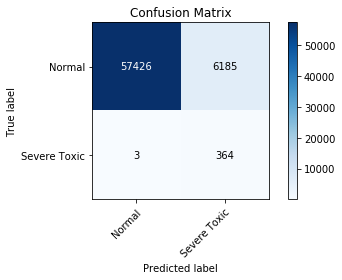

In [285]:
print("best threshold value:",best_train_threshold)
final_pred,predict_score = predict_score_estimator(test_y['severe_toxic'], y_pred_xgb,roc_auc_score,best_train_threshold)
print("ROC_AUC_Score for predict:", predict_score)
plot_confusion_matrix(test_y['severe_toxic'], final_pred, ["Normal","Severe Toxic"],
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues)

## Obscene Modelling

In [24]:
log_param_space1 = {"penalty": hp.choice("penalty", ['l1','l2']),
                   "fit_intercept" : hp.choice("fit_intercept", [True]),
                   "C": hp.choice("C", list(np.logspace(-3,3,300))),
                   "max_iter":hp.choice("max_iter", [100,200,500,1000]),
                    "class_weight":hp.choice("class_weight", ["balanced",None]),
                   "n_jobs":hp.choice("n_jobs", [3])}

bayes_opt(LogisticRegression,log_param_space1,tf_train_x,train_y['obscene'],"roc_auc")

100%|██████████| 100/100 [13:36:54<00:00, 490.15s/it, best loss: -0.9871599504754262]     

##### Results
Score best parameters:  0.9871599504754262
Best parameters:  {'C': 154, 'class_weight': 0, 'fit_intercept': 0, 'max_iter': 1, 'n_jobs': 0, 'penalty': 1}


In [90]:
lSVC_param_space1 = {"fit_intercept" : hp.choice("fit_intercept", [True,False]),
                   "C": hp.choice("C", list(np.logspace(-3,3,300))),
                   "max_iter":hp.choice("max_iter", [100,200,500,1000,2000]),
                "class_weight":hp.choice("class_weight", ["balanced",None])}

bayes_opt(LinearSVC,lSVC_param_space1,tf_train_x,train_y['obscene'],"roc_auc")

100%|██████████| 100/100 [26:13<00:00, 15.73s/it, best loss: -0.9887989161511289]

##### Results
Score best parameters:  0.9887989161511289
Best parameters:  {'C': 89, 'class_weight': 1, 'fit_intercept': 0, 'max_iter': 4}


In [217]:
log_model_o = LogisticRegression(random_state=1234,
                               penalty='l2',
                               fit_intercept=True,
                               C=list(np.logspace(-3,3,300))[154],
                               max_iter=200,
                               class_weight="balanced",
                               n_jobs=3)

In [218]:
log_model_o.fit(tf_train_x,train_y['obscene'])
y_pred_log_o_proba = log_model_o.predict_proba(tf_X_test)[:,1]
print("ROC_AUC_Score for predict proba:", roc_auc_score(test_y['obscene'], y_pred_log_o_proba))

ROC_AUC_Score for predict proba: 0.9756755185438575


### Calculation to get Best Threshold for Predict

In [267]:
log_model_o = LogisticRegression(random_state=1234,
                               penalty='l2',
                               fit_intercept=True,
                               C=list(np.logspace(-3,3,300))[154],
                               max_iter=200,
                               class_weight="balanced",
                               n_jobs=3)
best_train_score,best_train_threshold = cal_threshold(log_model_o,tf_train_x,train_y['obscene'], len(train_y['obscene']), roc_auc_score)

best threshold value: 0.23000000000000004
ROC_AUC_Score for predict: 0.9203059683128544


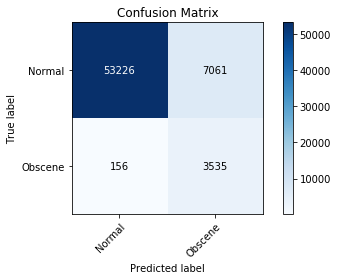

In [268]:
print("best threshold value:",best_train_threshold)
final_pred,predict_score = predict_score_estimator(test_y['obscene'], y_pred_log_o_proba,roc_auc_score,best_train_threshold)
print("ROC_AUC_Score for predict:", predict_score)
plot_confusion_matrix(test_y['obscene'], final_pred, ["Normal","Obscene"],
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues)

## Identity Hate Modelling

In [54]:
log_param_space1 = {"penalty": hp.choice("penalty", ['l1','l2']),
                   "fit_intercept" : hp.choice("fit_intercept", [True]),
                   "C": hp.choice("C", list(np.logspace(-3,3,300))),
                   "max_iter":hp.choice("max_iter", [100,200,500,1000]),
                    "class_weight":hp.choice("class_weight", ["balanced",None]),
                   "n_jobs":hp.choice("n_jobs", [3])}

bayes_opt(LogisticRegression,log_param_space1,tf_train_x,train_y['identity_hate'],"roc_auc")

100%|██████████| 100/100 [14:01:12<00:00, 504.72s/it, best loss: -0.9768320743243564]   

##### Results
Score best parameters:  0.9768320743243564
Best parameters:  {'C': 130, 'class_weight': 0, 'fit_intercept': 0, 'max_iter': 0, 'n_jobs': 0, 'penalty': 1}


In [107]:
lSVC_param_space1 = {"fit_intercept" : hp.choice("fit_intercept", [True,False]),
                   "C": hp.choice("C", list(np.logspace(-3,3,300))),
                   "max_iter":hp.choice("max_iter", [100,200,500,1000,2000]),
                "class_weight":hp.choice("class_weight", ["balanced",None])}

bayes_opt(LinearSVC,lSVC_param_space1,tf_train_x,train_y['identity_hate'],"roc_auc")

100%|██████████| 100/100 [19:05<00:00, 11.46s/it, best loss: -0.9762316555891382]

##### Results
Score best parameters:  0.9762316555891382
Best parameters:  {'C': 62, 'class_weight': 0, 'fit_intercept': 0, 'max_iter': 3}


In [222]:
log_model_i = LogisticRegression(random_state=1234,
                               penalty='l2',
                               fit_intercept=True,
                               C=list(np.logspace(-3,3,300))[130],
                               max_iter=100,
                               class_weight="balanced",
                               n_jobs=3)

In [223]:
log_model_i.fit(tf_train_x,train_y['identity_hate'])
y_pred_log_i_proba = log_model_i.predict_proba(tf_X_test)[:,1]
print("ROC_AUC_Score for predict proba:", roc_auc_score(test_y['identity_hate'], y_pred_log_i_proba))

ROC_AUC_Score for predict proba: 0.9807530035480655


### Calculation to get Best Threshold for Predict

In [269]:
log_model_i = LogisticRegression(random_state=1234,
                               penalty='l2',
                               fit_intercept=True,
                               C=list(np.logspace(-3,3,300))[130],
                               max_iter=100,
                               class_weight="balanced",
                               n_jobs=3)
best_train_score,best_train_threshold = cal_threshold(log_model_i,tf_train_x,train_y['identity_hate'], len(train_y['identity_hate']), roc_auc_score)

best threshold value: 0.17600000000000002
ROC_AUC_Score for predict: 0.9283592204059407


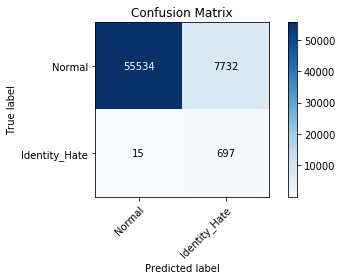

In [270]:
print("best threshold value:",best_train_threshold)
final_pred,predict_score = predict_score_estimator(test_y['identity_hate'], y_pred_log_i_proba,roc_auc_score,best_train_threshold)
print("ROC_AUC_Score for predict:", predict_score)
plot_confusion_matrix(test_y['identity_hate'], final_pred, ["Normal",'Identity_Hate'],
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues)